In [1]:
cd /SNS/users/lj7/dv/sns-chops/resolution/ARCS/

/SNS/users/lj7/dv/sns-chops/resolution/ARCS


In [2]:
#Program to load Vanadium or empty Can powder files and perform a constant-Q cut along the middle Q to look at energy resolution and intensity.
import matplotlib.pyplot as plt
from mantid import plots
from mantid.simpleapi import Load, ConvertToMD, BinMD, ConvertUnits, Rebin
from matplotlib.colors import LogNorm
import numpy as np
import mantid.simpleapi as msa
from mantid import mtd
import scipy

In [3]:
%matplotlib notebook

In [4]:
# ls /SNS/ARCS/IPTS-21387/nexus/

In [5]:
IPTS=21387
datadir="/SNS/ARCS/IPTS-"+str(IPTS)+"/shared/autoreduce/"

# gather data
**This can be skipped the 2nd time running this notebook**

In [6]:
RunNumber = 108101

In [7]:
"/SNS/ARCS/IPTS-"+str(IPTS)+"/nexus/ARCS_"+str(RunNumber)+'.nxs.h5'

'/SNS/ARCS/IPTS-21387/nexus/ARCS_108101.nxs.h5'

<IPython.core.display.Javascript object>


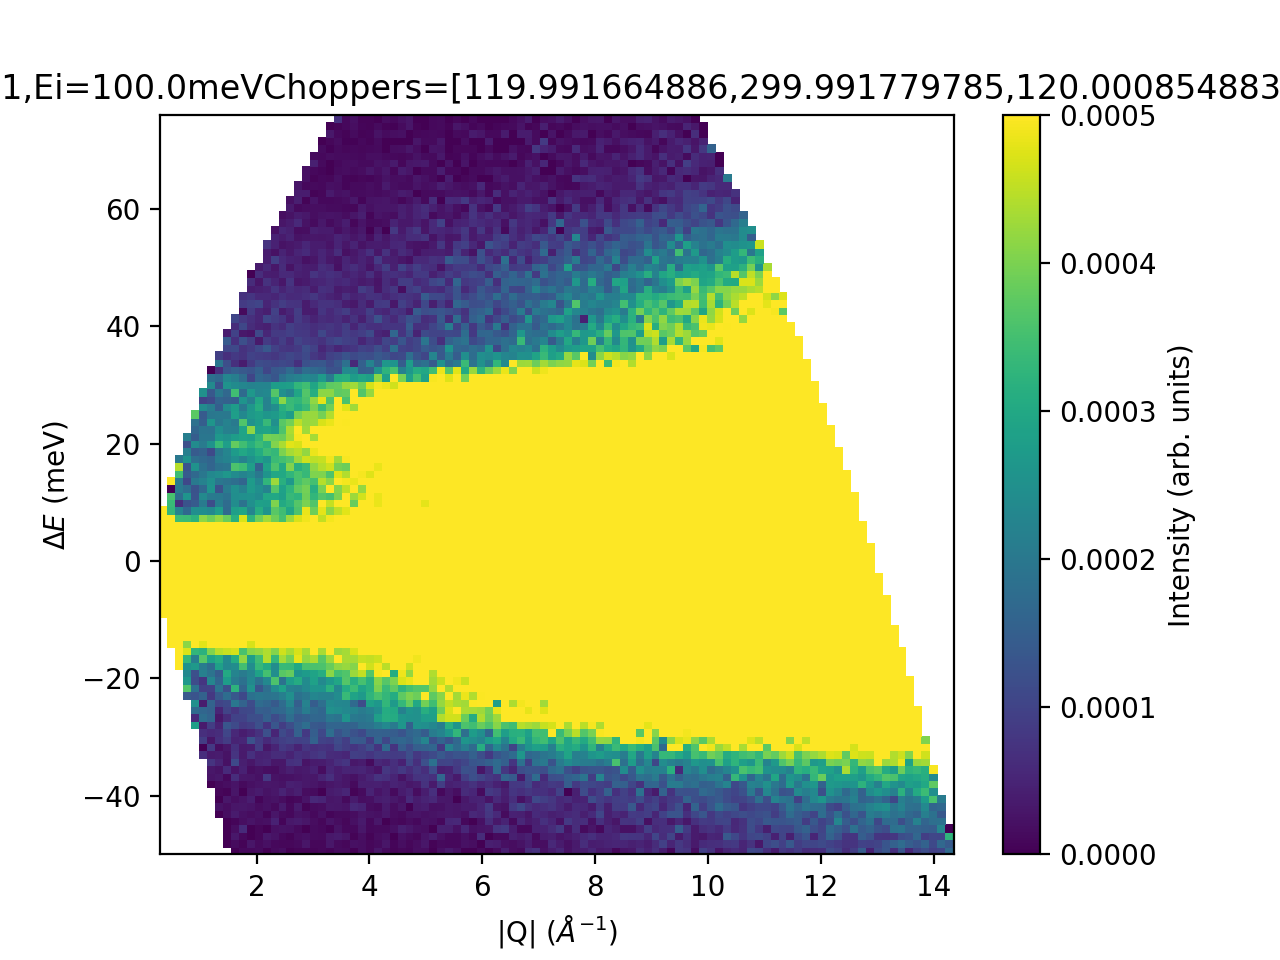

/SNS/software/miniconda2/envs/mcvine-unstable/lib/python2.7/site-packages/mantid/plots/helperfunctions.py:154: RuntimeWarning: invalid value encountered in true_divide
  data /= nev


<IPython.core.display.Javascript object>


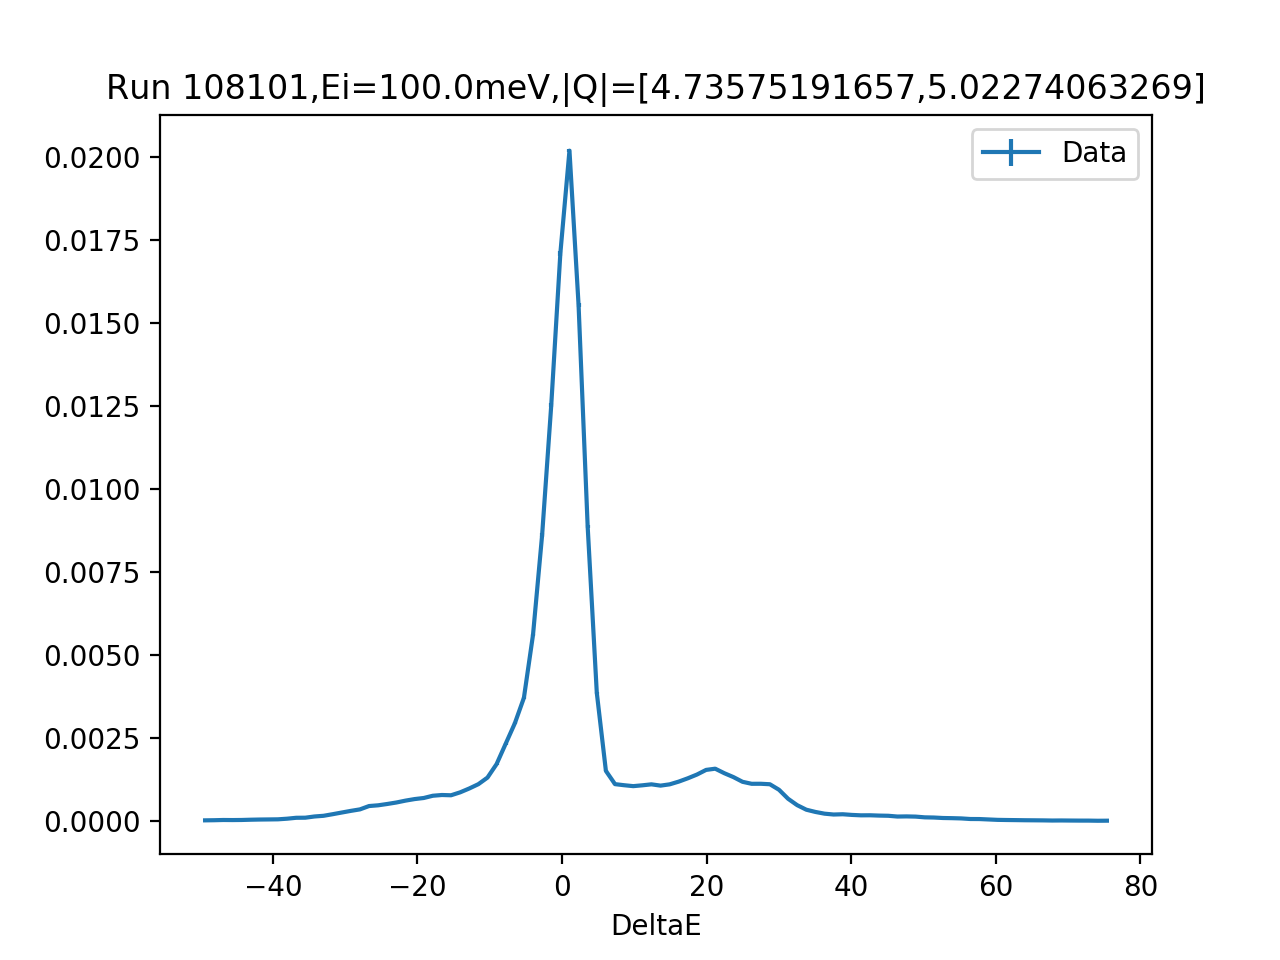

('Run=', 108101, ', Energy=', 100.0, 'meV, Chopper=', 2, 'ChopperPosition=', 432.99999611000004)
CPU times: user 3.53 s, sys: 1.33 s, total: 4.86 s
Wall time: 6.17 s


In [8]:
%%time
w=msa.CreateSingleValuedWorkspace()
#LoadNexusLogs(w,"/SNS/ARCS/IPTS-"+str(IPTS)+"/data/ARCS_"+str(RunNumber)+'_event.nxs')
msa.LoadNexusLogs(w,"/SNS/ARCS/IPTS-"+str(IPTS)+"/nexus/ARCS_"+str(RunNumber)+'.nxs.h5')
RunParams=w.getRun()
Energy=RunParams["BL18:Chop:Skf0:EnergyUserReq"].getStatistics().mean
#print Energy
Chopperpos=RunParams["chtrans"].getStatistics().mean
#print Chopperpos
Chopper1=RunParams["Speed1"].getStatistics().mean
Chopper2=RunParams["Speed2"].getStatistics().mean
Chopper3=RunParams["Speed3"].getStatistics().mean
if Chopperpos>400: 
    Chopper=2 
elif Chopperpos<1: 
    Chopper=1 
else: 
    Chopper=0


# generate a nice 2D multi-dimensional workspace
data = msa.LoadNXSPE(datadir+'ARCS_'+str(RunNumber)+'_autoreduced.nxspe')
values=msa.ConvertToMDMinMaxLocal('data',QDimensions='|Q|', dEAnalysisMode='Direct')
minQ,minE=values.MinValues
maxQ,maxE=values.MaxValues

md = msa.ConvertToMD(InputWorkspace=data, QDimensions='|Q|', dEAnalysisMode='Direct')
sqw = msa.BinMD(InputWorkspace=md,
            AlignedDim0='|Q|,'+str(minQ)+','+str(maxQ)+',100',
            AlignedDim1='DeltaE,'+ str(minE) +',' +str(maxE*0.8) +',100')

fig, ax = plt.subplots(subplot_kw={'projection':'mantid'})
c = ax.pcolormesh(sqw, vmin=0., vmax=0.5e-3)
cbar=fig.colorbar(c)
cbar.set_label('Intensity (arb. units)') #add text to colorbar
ax.set_title('Run '+str(RunNumber)+',Ei='+str(Energy)+'meVChoppers=['+str(Chopper1)+','+str(Chopper2)+','+str(Chopper3)+']')
fig.show()


# generate a 1D multi-dimensional workspace


sqw_line= msa.BinMD(
    InputWorkspace=md,
    #AlignedDim0='|Q|,' +str((minQ+maxQ)/3-0.01*maxQ) +','+ str((minQ+maxQ)/3+0.01*maxQ) +',1',
    AlignedDim0='|Q|,%s,%s,1' % ((minQ*2+maxQ)/3 , (minQ+2*maxQ)/3),
    AlignedDim1='DeltaE,'+ str(minE) +',' +str(maxE*0.8) +',100')

sqw_line_Hist=msa.ConvertMDHistoToMatrixWorkspace('sqw_line', Normalization='NumEventsNormalization')

fig, ax = plt.subplots(subplot_kw={'projection':'mantid'})
c = ax.errorbar(sqw_line_Hist,label='Data')
ax.legend()
ax.set_title('Run '+str(RunNumber)+',Ei='+str(Energy)+'meV,|Q|=[' +str((minQ+maxQ)/3-0.01*maxQ) +','+ str((minQ+maxQ)/3+0.01*maxQ) +']' )
fig.show()

xbb, y, Err = sqw_line_Hist.extractX(), sqw_line_Hist.extractY(), sqw_line_Hist.extractE()
xbb.shape = y.shape = Err.shape = -1,
x = (xbb[1:]+xbb[:-1])/2
IE = x,y,Err

RunParams2=data.getRun()
Ei=RunParams2["Ei"].value
Q=(minQ+maxQ)/3
# array=[0,RunNumber, Energy, Ei, Chopper, round(Chopper1), round(Chopper2), round(Chopper3), Height, dHeight, Center, dCenter, Sigma, dSigma, Q]
print("Run=",RunNumber,", Energy=",Energy,"meV, Chopper=",Chopper,"ChopperPosition=",Chopperpos)


In [9]:
(minQ*2+maxQ)/3 , (minQ+2*maxQ)/3

(4.9753472805023193, 9.6623915433883667)

In [10]:
path = '/SNS/ARCS/IPTS-%s/nexus/ARCS_%s.nxs.h5' % (IPTS, RunNumber)

In [11]:
path

'/SNS/ARCS/IPTS-21387/nexus/ARCS_108101.nxs.h5'

In [12]:
mons = msa.LoadNexusMonitors(path)
print mons.getNumberHistograms()
print Energy

from mcni.utils import conversion as C

v = C.e2v(Energy)
print v

LM1 = 11.831
t = LM1/v*1e6
print t

2
100.0
4373.93313724
2704.88817016


In [13]:
mon1 = mons.getSpectrum(0)
tofs = mon1.getTofs()
weights = mon1.getWeights()
intensities, tofbbs = np.histogram(tofs, weights=weights, bins=100, range=(t*.8, t*1.2))
tofcenters = (tofbbs[1:]+tofbbs[:-1])/2

<IPython.core.display.Javascript object>


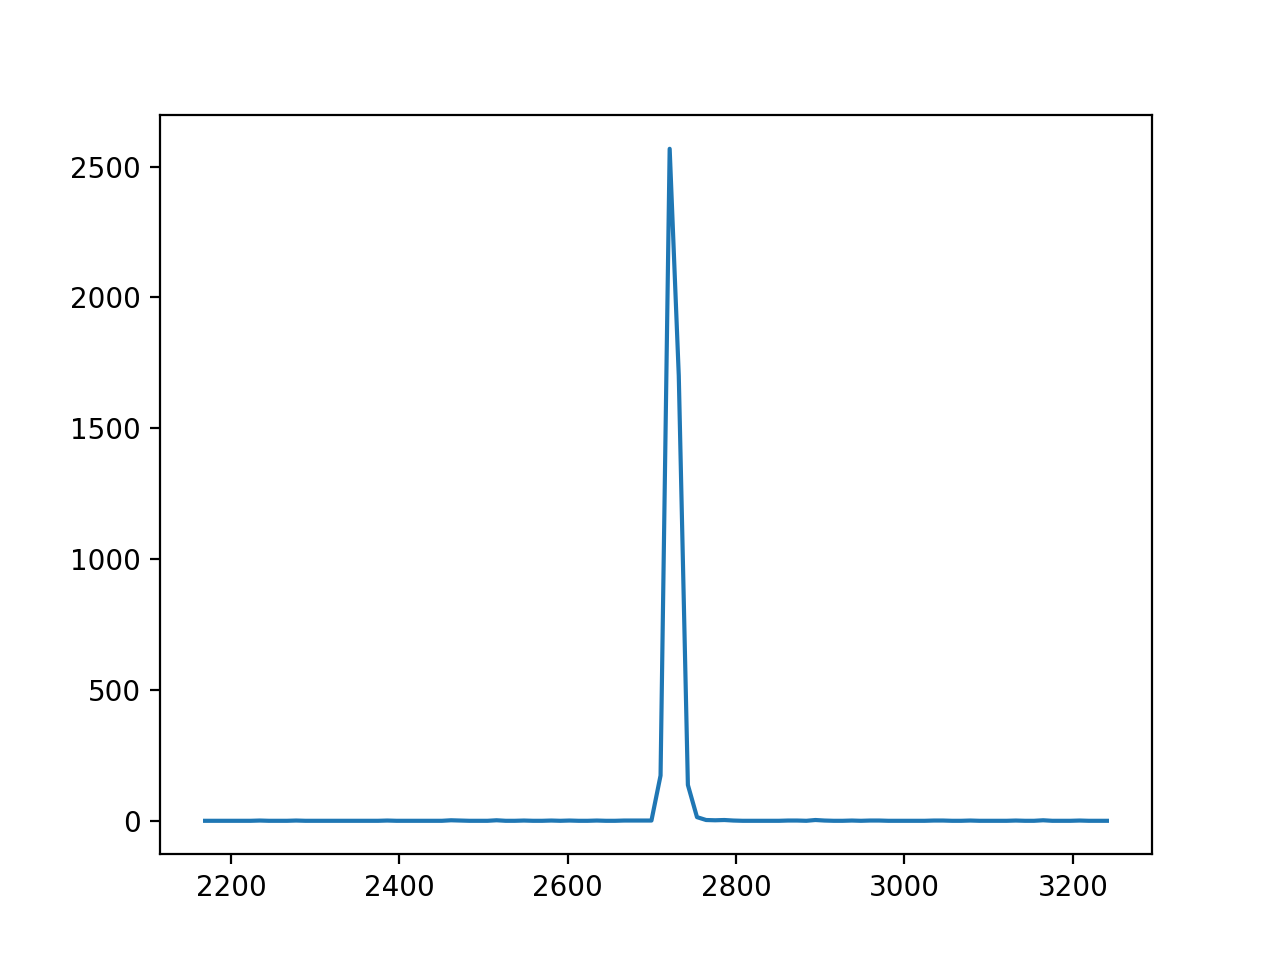

In [14]:
plt.figure()
plt.plot(tofcenters, intensities)

In [15]:
Chopper2

299.9917797851563

In [16]:
Chopper3

120.0008548834385

In [17]:
Ei

100.17220904371365

# Total counts?

In [19]:
ws = msa.Load('/SNS/ARCS/IPTS-21387/nexus/ARCS_108101.nxs.h5')

In [20]:
ws = msa.ConvertUnits(InputWorkspace=ws, Target='dSpacing', EMode='Elastic')

In [21]:
I_d = msa.Rebin(InputWorkspace=ws, Params='0,0.01,11')

In [22]:
I_d_sum = msa.SumSpectra(InputWorkspace=I_d)

In [23]:
xbb0 = I_d_sum.readX(0); y0 = I_d_sum.readY(0).copy()
x0 = (xbb0[1:] + xbb0[:-1])/2

<IPython.core.display.Javascript object>


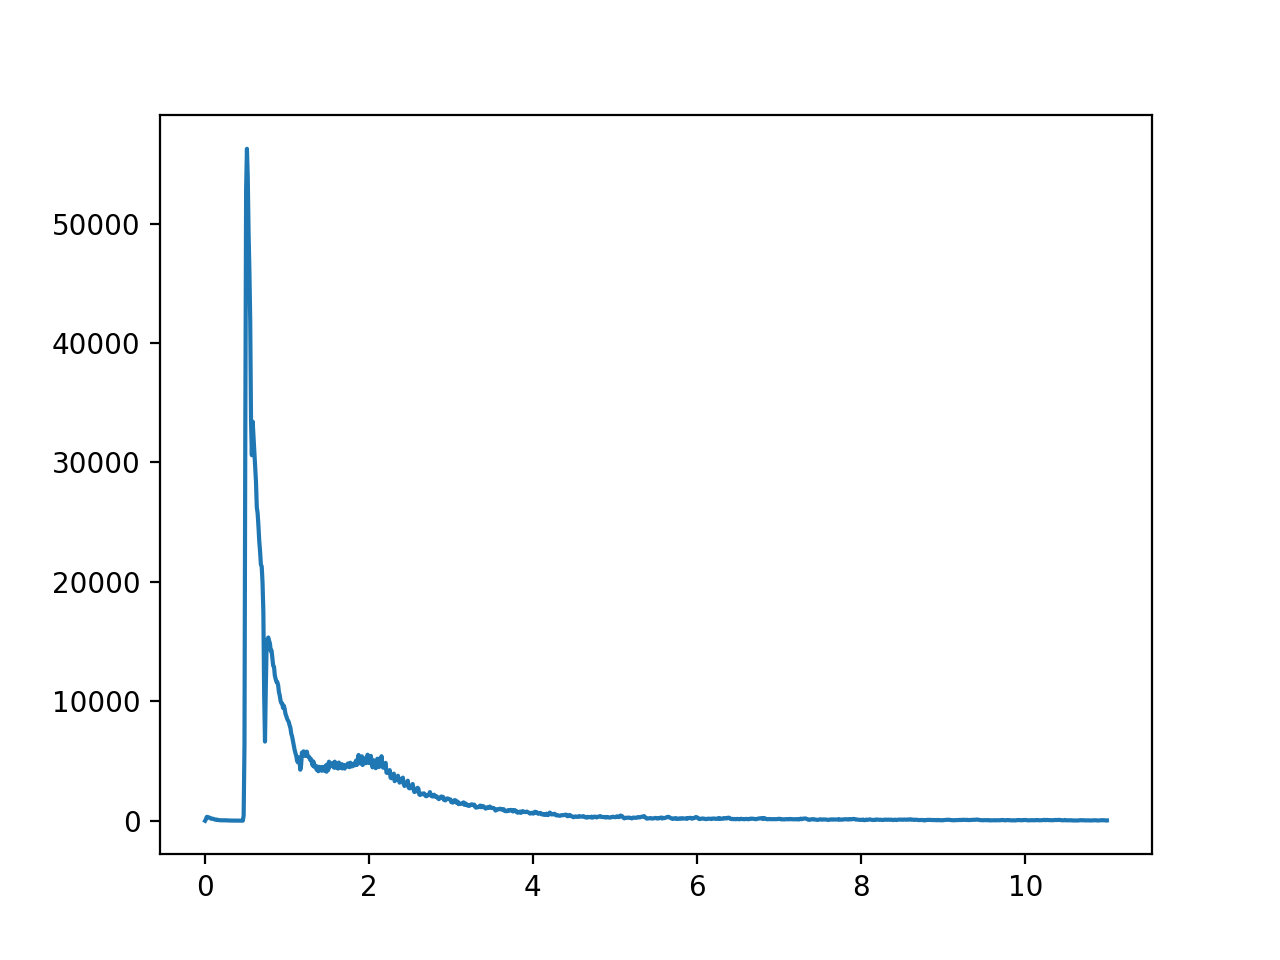

In [28]:
plt.figure()
plt.plot(x0,y0)

In [25]:
y0.sum()

2134368.0

In [26]:
print RunParams['start_time'].value
print RunParams['end_time'].value
print RunParams['duration'].value

2018-06-10T19:46:37.931993666
2018-06-10T19:51:48.012381666


RuntimeError: Unknown property search object duration

* 5 minutes
* 5X60X60 pulses = 18000

In [27]:
ws.getNumberEvents()

2154672